# Data exploration notebook for the SIDER datasete

## 1. Import and process dataset

In [23]:
import deepchem as dc
import pandas as pd
import numpy as np

# Helper function to combine ECFP and SMILES datasets
def dataset_to_df_with_smiles(ecfp_dataset, raw_dataset, tasks):
    X_list, y_list, ids_list, smiles_list = [], [], [], []
    
    # Iterate through both datasets in parallel
    for (X_batch, y_batch, w_batch, ids_batch), (X_raw, _, _, _) in zip(
        ecfp_dataset.iterbatches(batch_size=128, pad_batches=False),
        raw_dataset.iterbatches(batch_size=128, pad_batches=False)
    ):
        X_list.append(X_batch)
        y_list.append(y_batch)
        ids_list.extend(ids_batch)
        smiles_list.extend(X_raw)  # SMILES strings are in the raw features

    # Stack numerical and label arrays
    X_all = np.vstack(X_list)
    y_all = np.vstack(y_list)

    # Create DataFrames
    df_X = pd.DataFrame(X_all, columns=[f"fp_{i}" for i in range(X_all.shape[1])])
    df_y = pd.DataFrame(y_all, columns=tasks)
    df_y["mol_id"] = ids_list
    df_y["smiles"] = smiles_list

    # Combine all information into a single DataFrame
    df = pd.concat([df_y, df_X], axis=1)
    return df


# Load SIDER dataset with ECFP features (for model input)
tasks, datasets, transformers = dc.molnet.load_sider(featurizer='ECFP', splitter='scaffold')
train_ecfp, valid_ecfp, test_ecfp = datasets

# Load SIDER dataset again with raw SMILES (for visualization / metadata)
_, datasets_raw, _ = dc.molnet.load_sider(featurizer='Raw', splitter='scaffold')
train_raw, valid_raw, test_raw = datasets_raw

# Convert both representations to DataFrames
df_train = dataset_to_df_with_smiles(train_ecfp, train_raw, tasks)
df_valid = dataset_to_df_with_smiles(valid_ecfp, valid_raw, tasks)
df_test  = dataset_to_df_with_smiles(test_ecfp,  test_raw,  tasks)

# Basic dataset info
print(f"Number of tasks (side effects): {len(tasks)}")
print(f"Train samples: {len(df_train)}")
print(f"Validation samples: {len(df_valid)}")
print(f"Test samples: {len(df_test)}")

# Display the first few rows
df_train.head()



Number of tasks (side effects): 27
Train samples: 1141
Validation samples: 143
Test samples: 143


,Hepatobiliary disorders,Metabolism and nutrition disorders,Product issues,Eye disorders,Investigations,Musculoskeletal and connective tissue disorders,Gastrointestinal disorders,Social circumstances,Immune system disorders,Reproductive system and breast disorders,...,fp_1014,fp_1015,fp_1016,fp_1017,fp_1018,fp_1019,fp_1020,fp_1021,fp_1022,fp_1023
0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


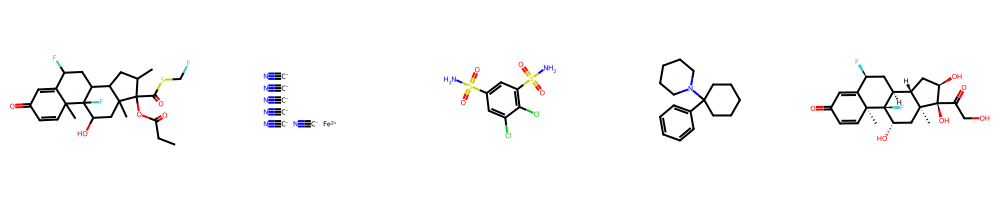

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert the first 5 SMILES into RDKit molecule objects
mols = [smi for smi in df_train["smiles"].head(5)]

# Display them in a grid
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

In [25]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter

# Helper function to extract the Bemis–Murcko scaffold SMILES
def get_scaffold(smiles_or_mol):
    if isinstance(smiles_or_mol, str):
        mol = Chem.MolFromSmiles(smiles_or_mol)
    else:
        mol = smiles_or_mol
    if mol is None:
        return None
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

# Compute scaffolds for each split
df_train["scaffold"] = df_train["smiles"].apply(get_scaffold)
df_valid["scaffold"] = df_valid["smiles"].apply(get_scaffold)
df_test["scaffold"]  = df_test["smiles"].apply(get_scaffold)

# Count unique scaffolds
scaffolds_train = set(df_train["scaffold"].dropna())
scaffolds_valid = set(df_valid["scaffold"].dropna())
scaffolds_test  = set(df_test["scaffold"].dropna())

print("Unique scaffolds in train:", len(scaffolds_train))
print("Unique scaffolds in validation:", len(scaffolds_valid))
print("Unique scaffolds in test:", len(scaffolds_test))

# Check overlaps between splits
overlap_train_valid = scaffolds_train.intersection(scaffolds_valid)
overlap_train_test  = scaffolds_train.intersection(scaffolds_test)
overlap_valid_test  = scaffolds_valid.intersection(scaffolds_test)

print("\nScaffold overlaps:")
print(f"Train ↔ Validation: {len(overlap_train_valid)}")
print(f"Train ↔ Test: {len(overlap_train_test)}")
print(f"Validation ↔ Test: {len(overlap_valid_test)}")


Unique scaffolds in train: 582
Unique scaffolds in validation: 143
Unique scaffolds in test: 143

Scaffold overlaps:
Train ↔ Validation: 0
Train ↔ Test: 0
Validation ↔ Test: 0


### Train / Validation / Test Split and Scaffold Integrity Check

The SIDER dataset has been split using a **scaffold-based splitter**, ensuring that molecules sharing the same core chemical structure (Bemis–Murcko scaffold) are placed in the **same subset**.  
This prevents overly optimistic performance caused by structurally similar molecules appearing in both the training and test sets.

**Dataset distribution:**
- Training set: 1,141 samples (~80%)
- Validation set: 143 samples (~10%)
- Test set: 143 samples (~10%)

These proportions are reasonable for model training and evaluation, providing a sufficiently large training set while keeping representative validation and test sets.

**Scaffold overlap analysis:**
- Unique scaffolds in training: 582  
- Unique scaffolds in validation: 143  
- Unique scaffolds in test: 143  
- Overlaps between splits: **0**

This confirms that the scaffold split has been performed correctly — the model will be evaluated on **completely unseen molecular scaffolds**, ensuring a fair assessment of its generalization ability.

If future experiments show instability in validation or test performance, we could consider increasing the validation or test proportions for better statistical robustness.


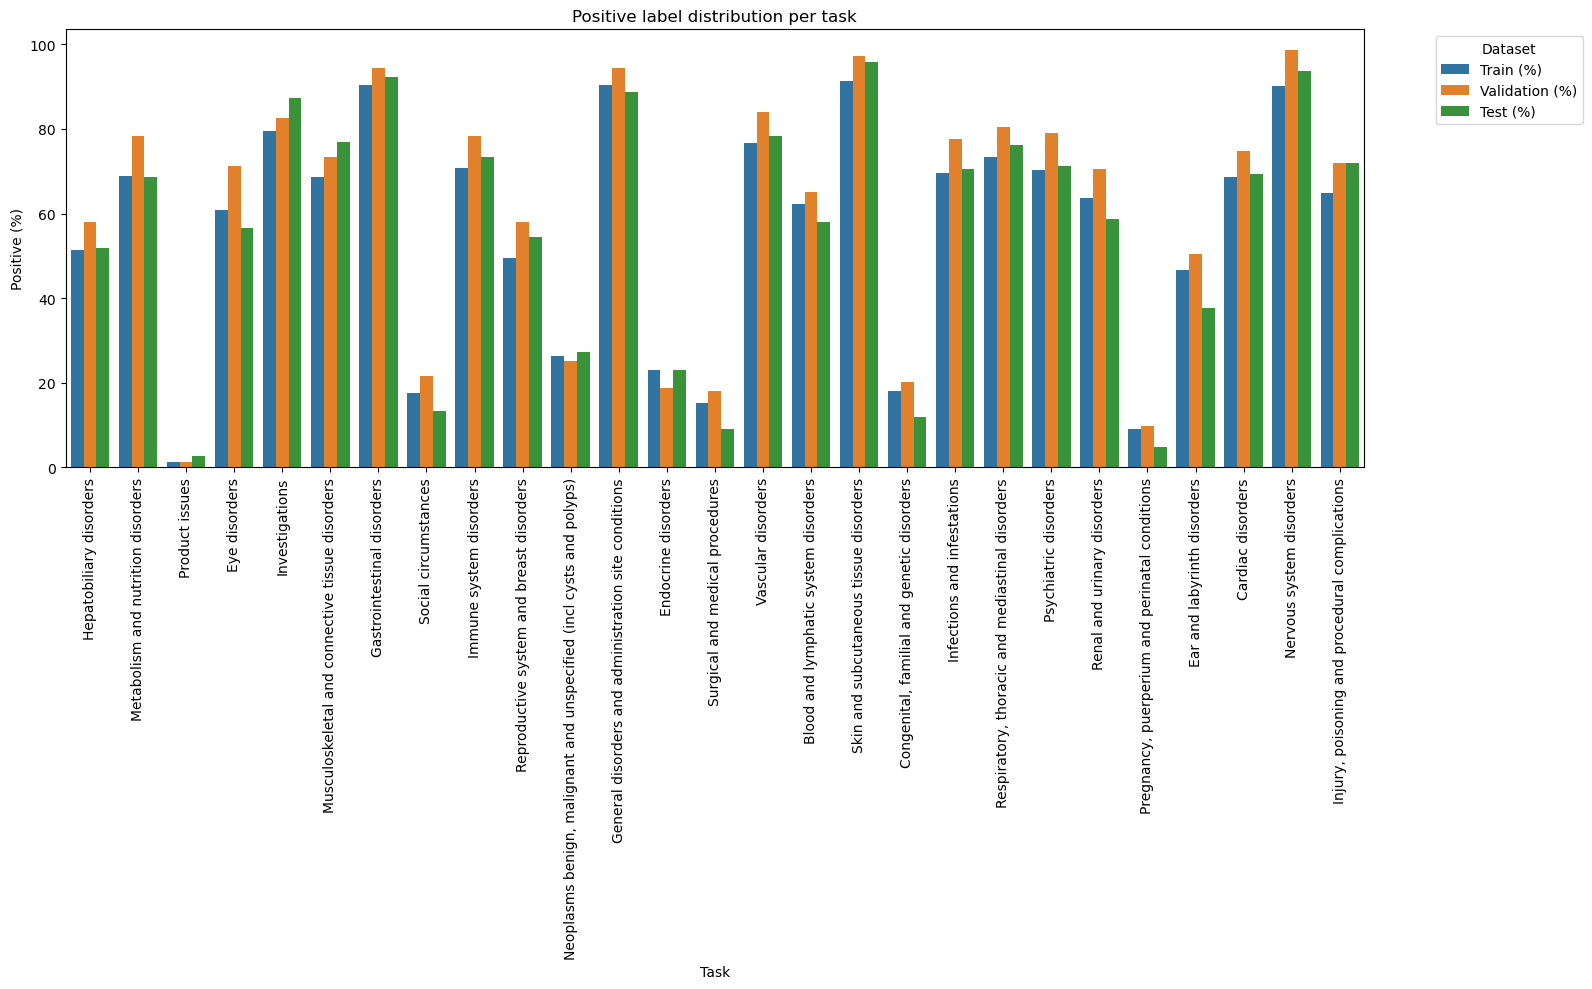

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Check label distribution ---
def plot_label_distribution(df_train, df_valid, df_test, tasks):
    train_pos = (df_train[tasks].sum() / len(df_train) * 100).round(2)
    valid_pos = (df_valid[tasks].sum() / len(df_valid) * 100).round(2)
    test_pos = (df_test[tasks].sum() / len(df_test) * 100).round(2)
    
    df_plot = pd.DataFrame({
        "Task": tasks,
        "Train (%)": train_pos.values,
        "Validation (%)": valid_pos.values,
        "Test (%)": test_pos.values
    })
    
    df_plot = df_plot.melt(id_vars="Task", var_name="Dataset", value_name="Positive (%)")
    
    plt.figure(figsize=(16,10))
    sns.barplot(data=df_plot, x="Task", y="Positive (%)", hue="Dataset")
    plt.xticks(rotation=90)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Positive label distribution per task")
    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, df_valid, df_test, tasks)


### Label Distribution Analysis

The distribution of side effect labels across tasks in the training set is highly imbalanced. Some labels are well represented, such as "Skin and subcutaneous tissue disorders" (1,042 samples) or "Gastrointestinal disorders" (1,031 samples), while others are extremely rare, like "Product issues" (16 samples) or "Cardiac disorders" (~69 samples).

This imbalance presents several challenges:

- Rare labels are difficult for the model to predict accurately.
- There is a higher risk of overfitting on tasks with very few positive examples.
- Evaluation metrics need to account for this imbalance to avoid misleading results.

Overall, while most tasks have enough samples for learning, special care is required for rare labels to ensure meaningful predictions.

### Label Distribution Visualization

The bar plot above shows the number of positive examples per side effect label in the training set. We can observe a highly imbalanced distribution:

- Some labels, like "Skin and subcutaneous tissue disorders" (~1,042 samples) and "Gastrointestinal disorders" (~1,031 samples), are very common.
- Others, like "Product issues" (16 samples) and "Cardiac disorders" (~69 samples), are extremely rare.
- Several labels fall in between, such as "Hepatobiliary disorders" (~586 samples) or "Immune system disorders" (~807 samples).

This visualization confirms that the dataset is not evenly distributed across tasks. When training models, this imbalance should be taken into account, for example by using weighted loss functions, oversampling rare labels, or carefully monitoring overfitting on rare classes.

Overall, the plot gives a clear picture of which tasks are easier to learn (well-represented labels) and which tasks may require special attention (rare labels).


Unique feature values: [0. 1.]
Constant features: 0 / 1024

Average activation (mean proportion of 1s): 0.0423
Min activation: 0.0018, Max activation: 0.8081


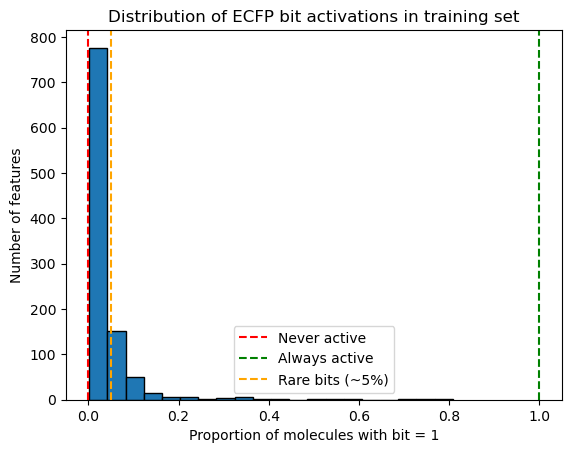

Bin 0.00-0.04 : 776 features
Bin 0.04-0.08 : 151 features
Bin 0.08-0.12 : 49 features
Bin 0.12-0.16 : 15 features
Bin 0.16-0.20 : 7 features
Bin 0.20-0.24 : 5 features
Bin 0.24-0.28 : 1 features
Bin 0.28-0.32 : 3 features
Bin 0.32-0.36 : 5 features
Bin 0.36-0.40 : 2 features
Bin 0.40-0.45 : 1 features
Bin 0.45-0.49 : 0 features
Bin 0.49-0.53 : 1 features
Bin 0.53-0.57 : 1 features
Bin 0.57-0.61 : 1 features
Bin 0.61-0.65 : 0 features
Bin 0.65-0.69 : 0 features
Bin 0.69-0.73 : 2 features
Bin 0.73-0.77 : 2 features
Bin 0.77-0.81 : 2 features


In [27]:
import numpy as np
import pandas as pd

# Select only ECFP feature columns
feature_cols = [col for col in df_train.columns if col.startswith("fp_")]
X_train = df_train[feature_cols]

# Check binary property
unique_values = np.unique(X_train.values)
print("Unique feature values:", unique_values)
assert set(unique_values).issubset({0, 1}), "⚠️ Non-binary values found in ECFP features!"

# Check for constant features
constant_features = [col for col in feature_cols if X_train[col].nunique() == 1]
print(f"Constant features: {len(constant_features)} / {len(feature_cols)}")

# Compute mean activation per feature
mean_activation = X_train.mean().sort_values(ascending=False)
print(f"\nAverage activation (mean proportion of 1s): {mean_activation.mean():.4f}")
print(f"Min activation: {mean_activation.min():.4f}, Max activation: {mean_activation.max():.4f}")

import numpy as np
import matplotlib.pyplot as plt

# X_train_bin : ton array binaire des features (shape: n_samples x n_features)
bit_frequencies = X_train.mean(axis=0)  # proportion de molécules où chaque bit = 1

# Créer un histogramme et récupérer les counts pour chaque bin
counts, bins, _ = plt.hist(bit_frequencies, bins=20, edgecolor='black')
plt.xlabel("Proportion of molecules with bit = 1")
plt.ylabel("Number of features")
plt.title("Distribution of ECFP bit activations in training set")

# Annotations pour rare / fréquents / constants
plt.axvline(0, color='red', linestyle='--', label='Never active')
plt.axvline(1, color='green', linestyle='--', label='Always active')
plt.axvline(0.05, color='orange', linestyle='--', label='Rare bits (~5%)')
plt.legend()
plt.show()

# Print des infos numériques
for i in range(len(counts)):
    print(f"Bin {bins[i]:.2f}-{bins[i+1]:.2f} : {int(counts[i])} features")


### ECFP Fingerprint Analysis

We analyzed the binary ECFP features of the training set to understand their distribution and informativeness.

**Feature statistics:**

- Unique values: `[0, 1]` → features are binary.  
- Constant features: `0 / 1024` → all features vary across molecules.  
- Average activation (proportion of 1s per bit): `0.0423` → most bits are rarely active.  
- Min / Max activation: `0.0018 / 0.8081` → some bits are very rare, a few are relatively frequent.

**Distribution summary:**

- **Mostly rare bits:** ~776 features active in <4% of molecules.  
- **Intermediate frequency bits:** ~227 features active in 4–20% of molecules.  
- **Frequent bits:** very few features active in >40% of molecules.  

**Interpretation:**

The ECFP fingerprint matrix is **sparse**, which is typical. Most bits capture rare substructures, providing fine-grained molecular information, while a few bits correspond to more common motifs. Models trained on this data need to handle sparsity appropriately, for example via regularization or algorithms robust to rare features.


In [28]:
for task in tasks:
    unique_vals = df_train[task].unique()
    print(f"{task}: {unique_vals}")

Hepatobiliary disorders: [0. 1.]
Metabolism and nutrition disorders: [1. 0.]
Product issues: [0. 1.]
Eye disorders: [1. 0.]
Investigations: [1. 0.]
Musculoskeletal and connective tissue disorders: [1. 0.]
Gastrointestinal disorders: [1. 0.]
Social circumstances: [0. 1.]
Immune system disorders: [1. 0.]
Reproductive system and breast disorders: [0. 1.]
Neoplasms benign, malignant and unspecified (incl cysts and polyps): [0. 1.]
General disorders and administration site conditions: [1. 0.]
Endocrine disorders: [0. 1.]
Surgical and medical procedures: [1. 0.]
Vascular disorders: [1. 0.]
Blood and lymphatic system disorders: [1. 0.]
Skin and subcutaneous tissue disorders: [1. 0.]
Congenital, familial and genetic disorders: [0. 1.]
Infections and infestations: [1. 0.]
Respiratory, thoracic and mediastinal disorders: [1. 0.]
Psychiatric disorders: [1. 0.]
Renal and urinary disorders: [1. 0.]
Pregnancy, puerperium and perinatal conditions: [0. 1.]
Ear and labyrinth disorders: [1. 0.]
Cardiac 

---
### Baseline Modeling

Now that the dataset has been explored and verified — including the structure, label balance, and feature sparsity — we can start testing basic machine learning models.

The goal of this section is to establish **baseline performances** using simple algorithms (e.g., Logistic Regression, Random Forest, or simple Neural Networks) on the ECFP features.  
These baselines will help us understand how well standard models can capture relationships between molecular fingerprints and side effects before moving to more complex or specialized architectures.


### First wee need to evaluate our models 

All our models will be evaluated by the same metrics :

- **Subset Accuracy**  
  Measures the fraction of samples where *all* labels are correctly predicted.  
  → Very strict metric; typically **low** in multilabel tasks.  
  **Good model:** > 0.5 is excellent.

- **Hamming Loss**  
  Fraction of labels that are incorrectly predicted (either 0 instead of 1 or vice versa).  
  → Lower is better.  
  **Good model:** close to 0 means few label errors.

- **Micro F1-score**  
  Aggregates contributions of all labels to compute a global F1.  
  → Favors frequent labels; robust to imbalance.  
  **Good model:** > 0.6–0.7 generally indicates solid performance.

- **Macro F1-score**  
  Averages F1 across all labels equally.  
  → Highlights performance on *rare* labels.  
  **Good model:** similar to Micro-F1; if much lower, the model struggles on rare labels.

- **Weighted F1-score**  
  Weighted average of F1 by label frequency.  
  → Balances importance between frequent and rare labels.  
  **Good model:** typically close to Micro-F1.

- **ROC-AUC (Micro / Macro)**  
  Measures the model’s ranking ability (probabilities).  
  → 1.0 = perfect separation, 0.5 = random guessing.  
  **Good model:** > 0.8 for Micro-AUC, > 0.7 for Macro-AUC is usually strong.


In [42]:
from sklearn.metrics import (
    accuracy_score, hamming_loss, f1_score, roc_auc_score
)

def evaluate_multilabel_model(y_true, y_pred, y_prob=None, name=None):
    """
    Evaluate multilabel classification performance.
    
    Parameters
    ----------
    y_true : np.ndarray
        Ground-truth binary matrix (n_samples x n_labels)
    y_pred : np.ndarray
        Predicted binary matrix (same shape as y_true)
    y_prob : np.ndarray, optional
        Predicted probabilities (for ROC-AUC if available)
    name : str
        Name of the dataframe evaluated
    """

    metrics = {"Nom :": name}
    metrics["Subset accuracy"] = accuracy_score(y_true, y_pred)
    metrics["Hamming loss"] = hamming_loss(y_true, y_pred)
    metrics["Micro F1"] = f1_score(y_true, y_pred, average="micro")
    metrics["Macro F1"] = f1_score(y_true, y_pred, average="macro")
    metrics["Weighted F1"] = f1_score(y_true, y_pred, average="weighted")
    
    if y_prob is not None:
        try:
            metrics["Micro ROC-AUC"] = roc_auc_score(y_true, y_prob, average="micro")
            metrics["Macro ROC-AUC"] = roc_auc_score(y_true, y_prob, average="macro")
        except ValueError:
            metrics["Micro ROC-AUC"] = np.nan
            metrics["Macro ROC-AUC"] = np.nan

    print("\n📊 Multilabel Evaluation Metrics:")
    for k, v in metrics.items():
        if isinstance(v, float):
            print(f"{k:20s}: {v:.4f}")
        else:
            print(f"{k:20s}: {v}")

    return metrics


## 1. Logistic regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# --- Prepare data ---
feature_cols = [col for col in df_train.columns if col.startswith("fp_")]
label_cols = [col for col in df_train.columns if col not in feature_cols + ['mol_id', 'smiles', 'scaffold']]

X_train = df_train[feature_cols].astype(float).values
y_train = df_train[label_cols].astype(float).values

X_valid = df_valid[feature_cols].astype(float).values
y_valid = df_valid[label_cols].astype(float).values

X_test = df_test[feature_cols].astype(float).values
y_test = df_test[label_cols].astype(float).values

# --- Train baseline model ---
print("Training baseline Logistic Regression model (One-vs-Rest)...")
model = OneVsRestClassifier(
    LogisticRegression(max_iter=500, solver='liblinear')
)
model.fit(X_train, y_train)

# --- Predict ---
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)


y_train_prob = model.predict_proba(X_train)
y_valid_prob = model.predict_proba(X_valid)
y_test_prob = model.predict_proba(X_test)

# --- Evaluate ---
evaluate_multilabel_model(y_train, y_train_pred, y_train_prob, "Train")
evaluate_multilabel_model(y_valid, y_valid_pred, y_valid_prob, "Validation")
evaluate_multilabel_model(y_test, y_test_pred, y_test_prob, "Test")

Training baseline Logistic Regression model (One-vs-Rest)...

📊 Multilabel Evaluation Metrics:
Nom :               : Train
Subset accuracy     : 0.6047
Hamming loss        : 0.0361
Micro F1            : 0.9679
Macro F1            : 0.9551
Weighted F1         : 0.9675
Micro ROC-AUC       : 0.9952
Macro ROC-AUC       : 0.9946

📊 Multilabel Evaluation Metrics:
Nom :               : Validation
Subset accuracy     : 0.0140
Hamming loss        : 0.2486
Micro F1            : 0.8004
Macro F1            : 0.6613
Weighted F1         : 0.7947
Micro ROC-AUC       : 0.8000
Macro ROC-AUC       : 0.5749

📊 Multilabel Evaluation Metrics:
Nom :               : Test
Subset accuracy     : 0.0000
Hamming loss        : 0.2707
Micro F1            : 0.7714
Macro F1            : 0.6223
Weighted F1         : 0.7726
Micro ROC-AUC       : 0.7920
Macro ROC-AUC       : 0.5956


{'Nom :': 'Test',
 'Subset accuracy': 0.0,
 'Hamming loss': 0.2706552706552707,
 'Micro F1': 0.7713848173266243,
 'Macro F1': 0.6222638991076471,
 'Weighted F1': 0.7725664660808413,
 'Micro ROC-AUC': 0.7920094526521456,
 'Macro ROC-AUC': 0.5955729697187505}